In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering

%matplotlib inline

In [2]:
df = pd.read_csv("./facebook_combined.txt.gz", compression='infer', sep=" ")
print(len(df))
df.head()

88233


,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [3]:
e = len(df)
v = len(np.unique(df["0"]))
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

facebook = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
%time facebook = facebook + facebook.T + eye(v)
facebook

88233 4039
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.55 ms


<4039x4039 sparse matrix of type '<class 'numpy.float64'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [4]:
n_clusters = int(v/20)

cl1 = SpectralCoclustering(n_clusters = n_clusters, n_jobs=2, svd_method='arpack', n_init=30)
%time cl1.fit(facebook)

CPU times: user 1.15 s, sys: 56 ms, total: 1.21 s
Wall time: 5.7 s


In [5]:
indices = [len(cl1.get_indices(i)[0]) for i in range(cl1.n_clusters)]

print(indices[:20])
print(np.mean(indices), np.std(indices), np.min(indices), np.max(indices))

[9, 10, 87, 90, 118, 150, 24, 167, 12, 20, 22, 50, 36, 1, 12, 1, 4, 5, 1, 2]
20.0945273632 35.809835219 1 212


In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

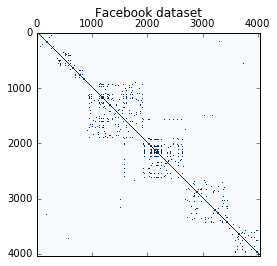

In [7]:
plt.matshow(facebook.toarray(), cmap=plt.cm.Blues)
plt.title("Facebook dataset")

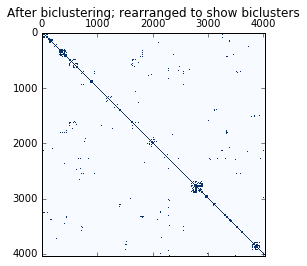

In [8]:
fit_data = facebook.toarray()[np.argsort(cl1.row_labels_)]
fit_data = fit_data[:, np.argsort(cl1.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

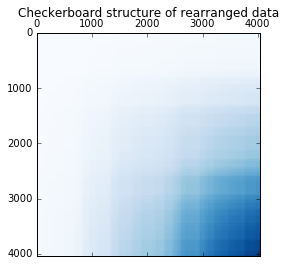

In [9]:
plt.matshow(np.outer(np.sort(cl1.row_labels_) + 1,
                     np.sort(cl1.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

In [10]:
cl1.row_labels_

array([194,   2, 174, ...,   1,   1, 168], dtype=int32)

In [11]:
import networkx as nx
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [12]:
x = np.array(df.to_records(index=False))
l = [(a,b) for a,b in x]
l[:10]

[(0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11)]

In [13]:
%time g = nx.Graph([(a,b) for a,b in df.to_records(index=False)])
g

CPU times: user 876 ms, sys: 4 ms, total: 880 ms
Wall time: 878 ms


22 22
(array([576, 577, 578, 582, 583, 595, 599, 600, 615, 627, 632, 640, 643,
       650, 658, 659, 661, 662, 665, 670, 675, 681]), array([576, 577, 578, 582, 583, 595, 599, 600, 615, 627, 632, 640, 643,
       650, 658, 659, 661, 662, 665, 670, 675, 681]))


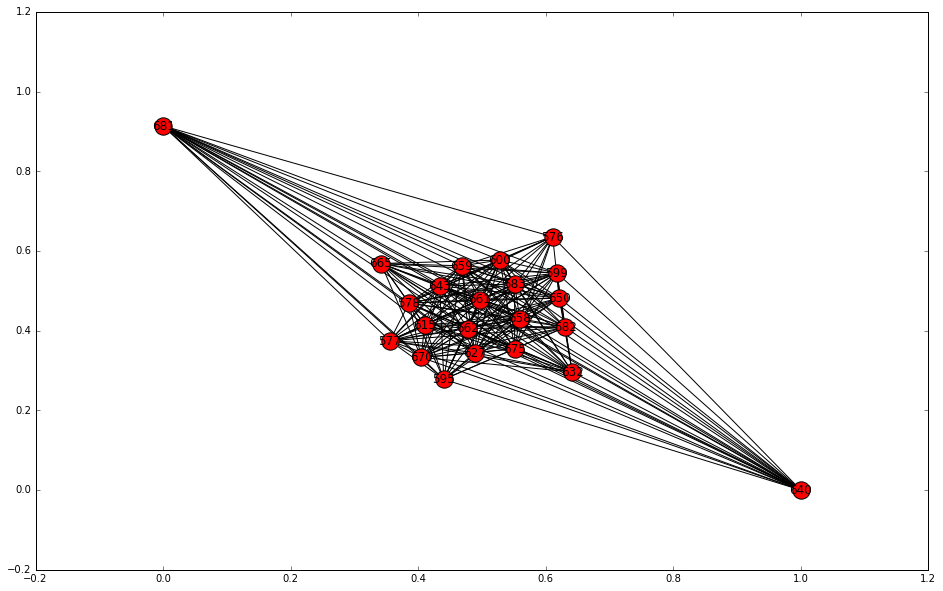

In [14]:
ind = cl1.get_indices(10)
print (len(ind[0]), len(ind[1]))
print(ind)
sub = g.subgraph(ind[0])

nx.draw_networkx(sub)

In [15]:
l = 621
print(df[df["0"]==l])
print(df[df["1"]==l])

        0    1
9177  621  622
9178  621  663
        0    1
6152  414  621
8551  574  621
8636  579  621
8826  592  621
9119  616  621


## Passage au Laplacien

In [16]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = facebook2 + facebook2.T

In [17]:
np.array(facebook2.sum(axis=0))[0]

array([ 346.,   16.,   10., ...,    2.,    4.,    9.])

In [18]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L

<4039x4039 sparse matrix of type '<class 'numpy.float64'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [19]:
from scipy.sparse.linalg import eigsh

In [20]:
n_clusters = int(L.shape[0]/20)
neig = 2 + int(np.log(n_clusters) / np.log(2))
print(n_clusters, neig)

%time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
eigval

201 9
CPU times: user 2.04 s, sys: 56 ms, total: 2.09 s
Wall time: 524 ms


array([ -1.31337543e-14,   1.81476472e-02,   2.89880331e-02,
         4.71877939e-02,   6.82694179e-02,   1.10552279e-01,
         1.63108060e-01,   6.78447046e-01,   7.33054090e-01])

In [21]:
eigvec

array([[ -1.57348669e-02,   7.97673453e-03,  -4.15270952e-03, ...,
          4.41631275e-03,   2.34310874e-04,   1.97127581e-07],
       [ -1.57348669e-02,   7.99488788e-03,  -4.16993461e-03, ...,
          3.94887944e-03,   1.95405185e-04,  -2.18128676e-07],
       [ -1.57348669e-02,   8.12166851e-03,  -4.27463018e-03, ...,
          5.23975854e-03,   6.94308835e-04,   1.33358157e-06],
       ..., 
       [ -1.57348669e-02,   1.28883042e-02,   1.30377533e-01, ...,
         -5.70757092e-03,   2.00720200e-03,  -3.43845741e-06],
       [ -1.57348669e-02,   1.27791859e-02,   1.28602815e-01, ...,
         -5.23292296e-03,   9.73710464e-04,  -1.84580630e-06],
       [ -1.57348669e-02,   1.24889378e-02,   1.23915741e-01, ...,
         -4.09052674e-03,  -5.75654707e-04,   9.09167480e-07]])

In [22]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

3285 754


(3, 4039)


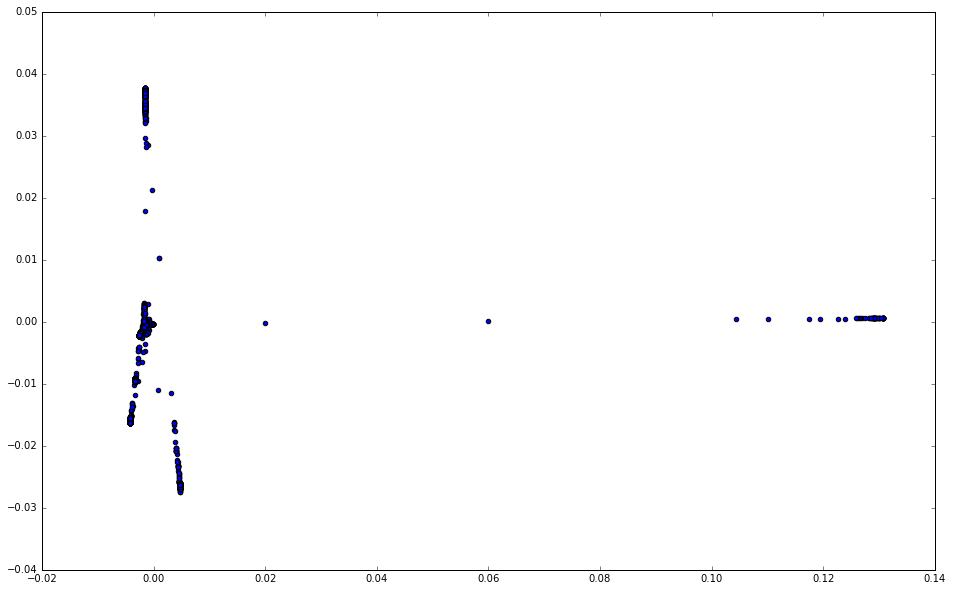

In [36]:
proj = eigvec[:, 2:5].T
print(proj.shape)

plt.scatter(proj[0], proj[1])

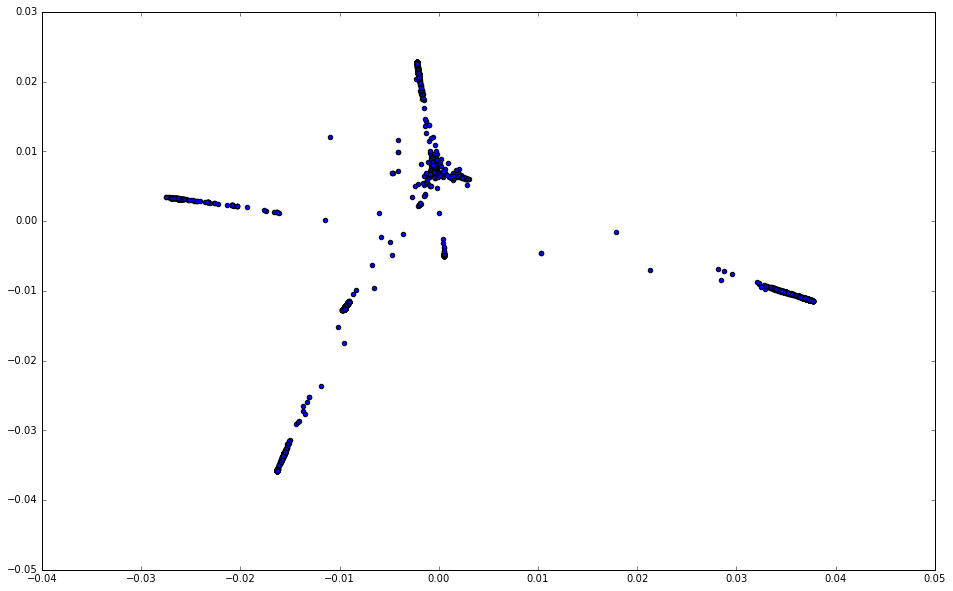

In [38]:
plt.scatter(proj[1], proj[2])

In [34]:
for i in np.where((proj[0] > 0.01) & (proj[0] < 0.12))[0]:
    print (i, proj[0][i], proj[1][i], L[i,i])

594 0.0600043374284 7.41595296123e-05 8.0
667 0.0200487687163 -0.000210030301251 3.0
3989 0.110079842314 0.000427023966429 6.0
3991 0.119348863195 0.000492516902371 3.0
4011 0.104404429318 0.000386678994843 4.0
4031 0.117546579678 0.000480156997071 11.0


In [67]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters = 5)

%time clusters = clf.fit_predict(eigvec)

CPU times: user 144 ms, sys: 24 ms, total: 168 ms
Wall time: 43 ms


In [68]:
print(eigvec.shape)
print(clf.cluster_centers_)
clusters

(4039, 9)
[[ -1.57348669e-02  -1.05338457e-03  -1.18706316e-03  -3.16567954e-03
    1.14553534e-02   2.14390746e-03   5.52847691e-03   4.57531373e-04
    1.91024642e-04]
 [ -1.57348669e-02   1.27433698e-02   1.28032950e-01   5.54707799e-04
   -4.71009938e-03   1.67303027e-03  -5.12263934e-03   1.16239763e-03
   -1.81523170e-06]
 [ -1.57348669e-02   6.91874288e-03  -3.30856797e-03  -9.27601552e-03
   -1.20108870e-02  -2.35487464e-02  -1.51839176e-02  -1.35807605e-03
    2.51762575e-06]
 [ -1.57348669e-02  -1.13756998e-02  -1.56557534e-03   3.60123483e-02
   -1.07019023e-02   1.84000810e-03  -4.86020559e-03  -4.28135495e-04
   -8.18437285e-04]
 [ -1.57348669e-02   8.02059940e-03  -4.19150566e-03  -1.57809272e-02
   -3.40055137e-02   3.40548890e-02   4.32122968e-03   3.48855447e-04
    2.91337355e-07]]


array([4, 4, 4, ..., 1, 1, 1], dtype=int32)

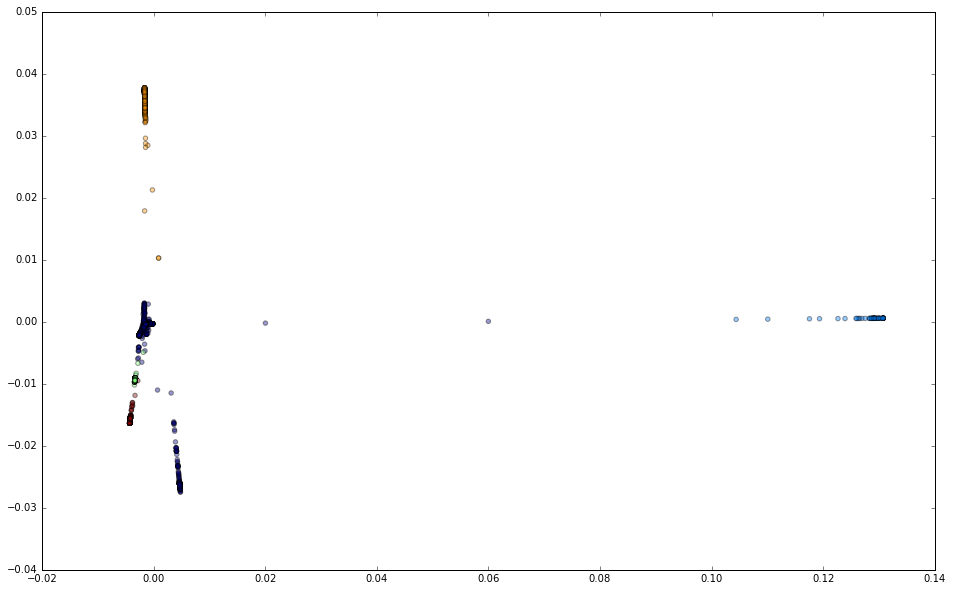

In [70]:
plt.scatter(proj[0], proj[1], c=clusters, alpha=0.4)